dataset from kaggle: https://www.kaggle.com/mathurinache/world-happiness-report

In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [31]:
import warnings
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import LeaveOneOutEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
import statsmodels.api as sm
import statsmodels.stats.api as sms
from scipy import stats

%matplotlib inline

<IPython.core.display.Javascript object>

In [32]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5


def print_vif(x):
    """Utility for checking multicollinearity assumption

    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

In [33]:
df = pd.read_csv("2020.csv")

<IPython.core.display.Javascript object>

# Goal

We want to build a model to predict the Ladder Score (happiness score on from 0-10)

# Let's do some quick EDA

In [34]:
df

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.8087,0.031156,7.869766,7.747634,10.639267,0.954330,71.900825,0.949172,-0.059482,0.195445,1.972317,1.285190,1.499526,0.961271,0.662317,0.159670,0.477857,2.762835
1,Denmark,Western Europe,7.6456,0.033492,7.711245,7.579955,10.774001,0.955991,72.402504,0.951444,0.066202,0.168489,1.972317,1.326949,1.503449,0.979333,0.665040,0.242793,0.495260,2.432741
2,Switzerland,Western Europe,7.5599,0.035014,7.628528,7.491272,10.979933,0.942847,74.102448,0.921337,0.105911,0.303728,1.972317,1.390774,1.472403,1.040533,0.628954,0.269056,0.407946,2.350267
3,Iceland,Western Europe,7.5045,0.059616,7.621347,7.387653,10.772559,0.974670,73.000000,0.948892,0.246944,0.711710,1.972317,1.326502,1.547567,1.000843,0.661981,0.362330,0.144541,2.460688
4,Norway,Western Europe,7.4880,0.034837,7.556281,7.419719,11.087804,0.952487,73.200783,0.955750,0.134533,0.263218,1.972317,1.424207,1.495173,1.008072,0.670201,0.287985,0.434101,2.168266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,Central African Republic,Sub-Saharan Africa,3.4759,0.115183,3.701658,3.250141,6.625160,0.319460,45.200001,0.640881,0.082410,0.891807,1.972317,0.041072,0.000000,0.000000,0.292814,0.253513,0.028265,2.860198
149,Rwanda,Sub-Saharan Africa,3.3123,0.052425,3.415053,3.209547,7.600104,0.540835,61.098846,0.900589,0.055484,0.183541,1.972317,0.343243,0.522876,0.572383,0.604088,0.235705,0.485542,0.548445
150,Zimbabwe,Sub-Saharan Africa,3.2992,0.058674,3.414202,3.184198,7.865712,0.763093,55.617260,0.711458,-0.072064,0.810237,1.972317,0.425564,1.047835,0.375038,0.377405,0.151349,0.080929,0.841031
151,South Sudan,Sub-Saharan Africa,2.8166,0.107610,3.027516,2.605684,7.425360,0.553707,51.000000,0.451314,0.016519,0.763417,1.972317,0.289083,0.553279,0.208809,0.065609,0.209935,0.111157,1.378751


<IPython.core.display.Javascript object>

What are our potential scores?

In [37]:
df["Ladder score"].value_counts()

3.7208    1
5.8724    1
5.5104    1
5.3535    1
6.0004    1
         ..
5.9109    1
3.5274    1
7.5045    1
4.5579    1
7.4880    1
Name: Ladder score, Length: 153, dtype: int64

<IPython.core.display.Javascript object>

Let's check out the columns and their types. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 20 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Country name                                153 non-null    object 
 1   Regional indicator                          153 non-null    object 
 2   Ladder score                                153 non-null    float64
 3   Standard error of ladder score              153 non-null    float64
 4   upperwhisker                                153 non-null    float64
 5   lowerwhisker                                153 non-null    float64
 6   Logged GDP per capita                       153 non-null    float64
 7   Social support                              153 non-null    float64
 8   Healthy life expectancy                     153 non-null    float64
 9   Freedom to make life choices                153 non-null    float64
 10  Generosity    

<IPython.core.display.Javascript object>

Let's check for NaNs.

In [7]:
df.isna().mean()

Country name                                  0.0
Regional indicator                            0.0
Ladder score                                  0.0
Standard error of ladder score                0.0
upperwhisker                                  0.0
lowerwhisker                                  0.0
Logged GDP per capita                         0.0
Social support                                0.0
Healthy life expectancy                       0.0
Freedom to make life choices                  0.0
Generosity                                    0.0
Perceptions of corruption                     0.0
Ladder score in Dystopia                      0.0
Explained by: Log GDP per capita              0.0
Explained by: Social support                  0.0
Explained by: Healthy life expectancy         0.0
Explained by: Freedom to make life choices    0.0
Explained by: Generosity                      0.0
Explained by: Perceptions of corruption       0.0
Dystopia + residual                           0.0


<IPython.core.display.Javascript object>

Below, I'm looking at values that highly correlated with the ladder score and selecting the most relevant to put into my model.

In [8]:
np.abs(round(df.iloc[:, 1:].corr().loc[:, "Ladder score"], 4)).sort_values(
    ascending=False
)

Ladder score                                  1.0000
upperwhisker                                  0.9996
lowerwhisker                                  0.9996
Explained by: Log GDP per capita              0.7754
Logged GDP per capita                         0.7754
Healthy life expectancy                       0.7703
Explained by: Healthy life expectancy         0.7703
Explained by: Social support                  0.7650
Social support                                0.7650
Explained by: Freedom to make life choices    0.5906
Freedom to make life choices                  0.5906
Dystopia + residual                           0.4803
Standard error of ladder score                0.4464
Explained by: Perceptions of corruption       0.4183
Perceptions of corruption                     0.4183
Explained by: Generosity                      0.0690
Generosity                                    0.0690
Ladder score in Dystopia                      0.0000
Name: Ladder score, dtype: float64

<IPython.core.display.Javascript object>

So we have a lot of highly correlated features.
Let's remove the whiskers since they are an extension of the ladder score (happiness score) and remove other redundant variables such as the 'explained' variables.  

In [9]:
df = df.drop(
    columns=[
        "upperwhisker",
        "lowerwhisker",
        "Ladder score in Dystopia",
        "Explained by: Log GDP per capita",
        "Explained by: Social support",
        "Explained by: Healthy life expectancy",
        "Explained by: Perceptions of corruption",
        "Explained by: Generosity",
        "Explained by: Freedom to make life choices",
        "Standard error of ladder score",
        "Country name",
    ],
    errors="ignore",
)

<IPython.core.display.Javascript object>

In [10]:
print_vif(df.drop(columns=["Regional indicator", "Ladder score"]))

VIF results
-------------------------------
const                           206.264854
Logged GDP per capita             4.591966
Social support                    3.030011
Healthy life expectancy           3.931947
Freedom to make life choices      1.625241
Generosity                        1.232240
Perceptions of corruption         1.425991
Dystopia + residual               1.020363
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

Great, we've lowered the multicolinearity by dropping some columns.

Now let's look at how our features related to our target variable

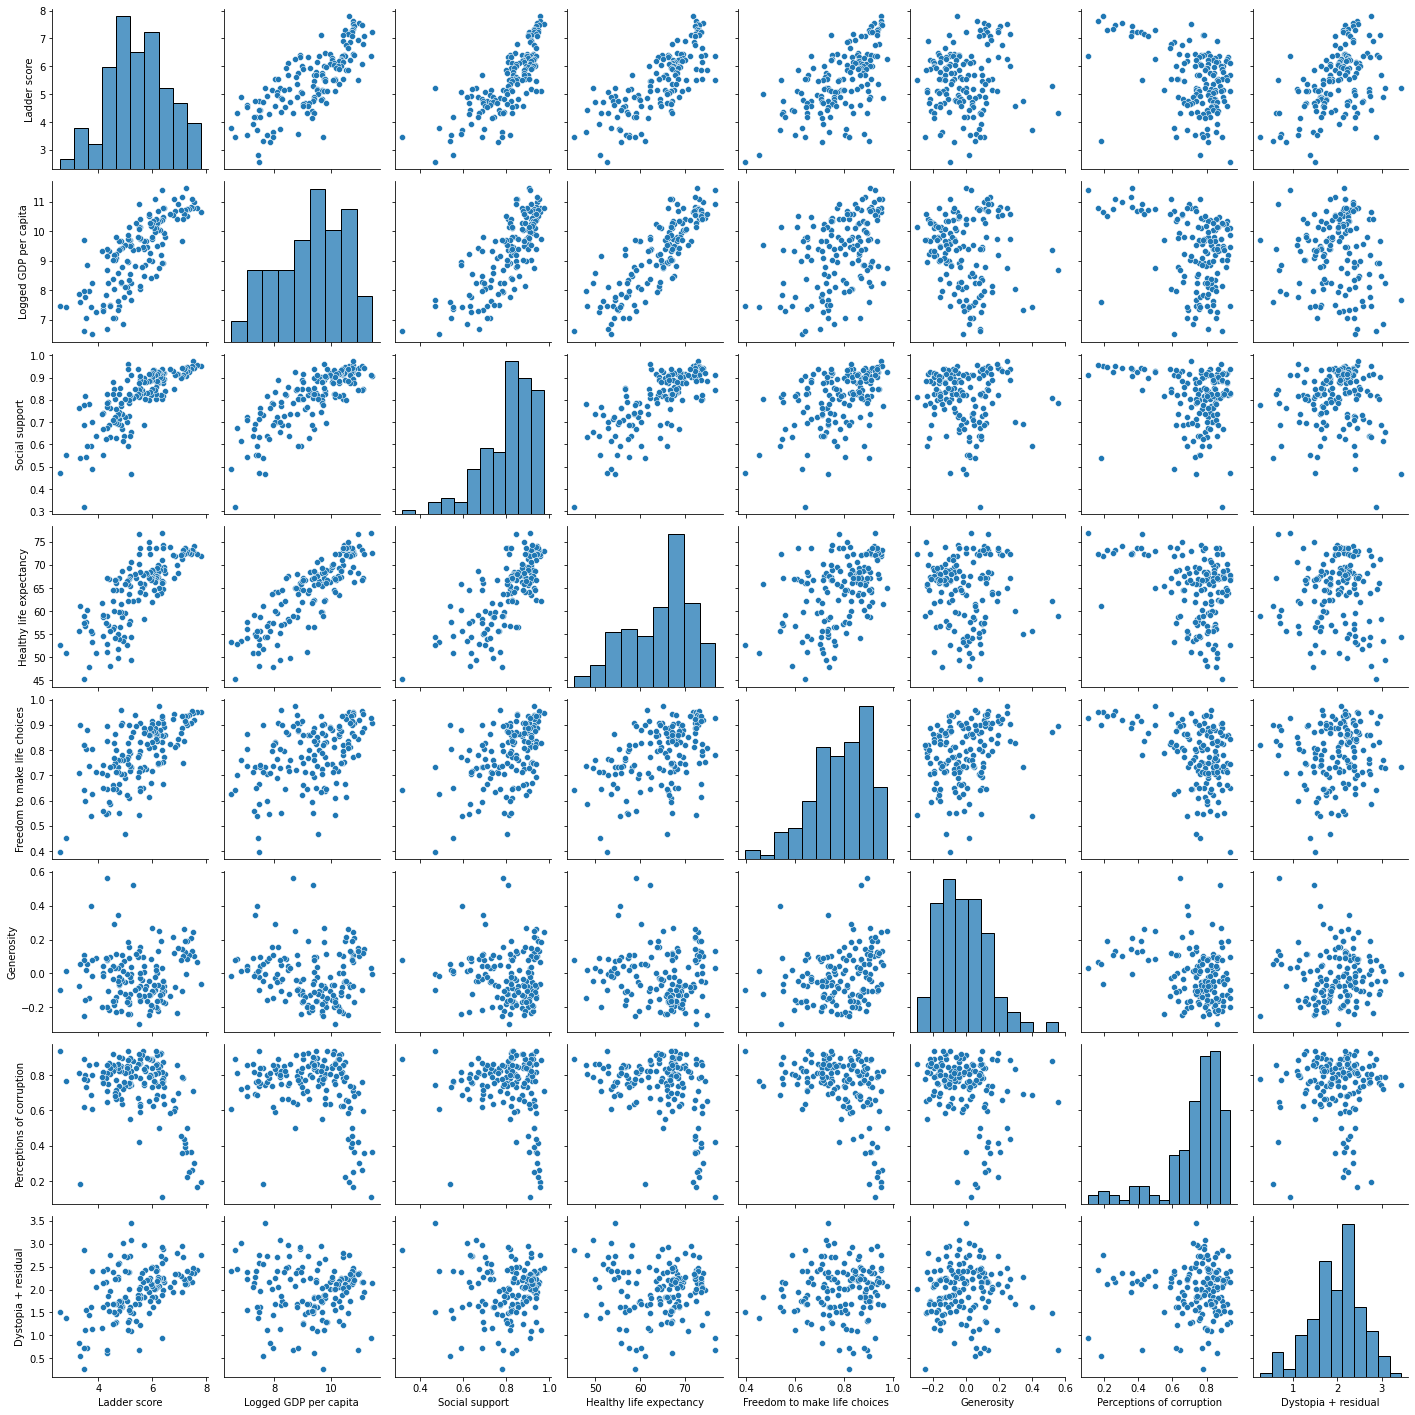

<IPython.core.display.Javascript object>

In [11]:
sns.pairplot(df)

So we have some variables that have a fairly linear relationship with ladder score and few that do not.

# Let's preprocess!

We'll scale our numeric variables and encode our cateforical variable.

In [12]:
num_cols = df.drop(columns=["Ladder score", "Regional indicator"]).columns

cat_cols = ["Regional indicator"]
drop_cats = ["Sub-Saharan Africa"]

<IPython.core.display.Javascript object>

We need to seperate our target variable from the predicting variables and then split our test and train data.

In [13]:
X = df.drop(columns="Ladder score")
y = df["Ladder score"]

<IPython.core.display.Javascript object>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

<IPython.core.display.Javascript object>

In [15]:
preprocessing = ColumnTransformer(
    [
        ("scale", StandardScaler(), num_cols),
        ("encode", LeaveOneOutEncoder(), cat_cols),
    ],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

# Now we'll build our pipeline and run our model

In [16]:
pipeline = Pipeline(
    [
        ("preprocessing", preprocessing),
        #         ("model", XGBRegressor(n_estimators=50, learning_rate=0.1)),
        #         ("model", Lasso()),
        ("model", ElasticNet()),
    ]
)

<IPython.core.display.Javascript object>

Since we saw linear patterns in our scatterplots we'll go with a Linear Model. We'll use an elastic net linear model to reduce coefficients and elimanate features thats aren't useul

In [17]:
grid = {
    #     "model__subsample": [0.5, 0.75, 1.0],
    #     "model__colsample_bytree": [0.4, 0.6, 0.8, 1.0],
    #     "model__max_depth": [4, 6, 8, 10],
    #     "model__alpha": [0.1, 0.5, 1, 5]
    "model__alpha": [0.0001, 0.001, 0.01, 0.1],
    "model__l1_ratio": [0.1, 0.5, 0.75, 1],
}

<IPython.core.display.Javascript object>

In [18]:
pipeline_cv = GridSearchCV(pipeline, grid, cv=5, verbose=1, n_jobs=-1)
pipeline_cv.fit(X_train, y_train)

train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)
print(f"train R^2 score {train_score}")
print(f"test R^2 score {test_score}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s


train R^2 score 0.9999999791452153
test R^2 score 0.9999999775849109


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    6.2s finished


<IPython.core.display.Javascript object>

In [19]:
pipeline_cv.best_params_

{'model__alpha': 0.0001, 'model__l1_ratio': 0.1}

<IPython.core.display.Javascript object>

# Evaluate model

In [20]:
pipeline_cv.best_estimator_["model"].coef_

array([ 3.83334605e-01,  2.93246458e-01,  2.60482986e-01,  1.43767677e-01,
        1.02252930e-01, -1.17520159e-01,  5.54727116e-01,  2.49596505e-04])

<IPython.core.display.Javascript object>

In [27]:
best_model = pipeline_cv.best_estimator_
ceofs = best_model["model"].coef_

ceof_df = pd.DataFrame({"feat": X_train.columns, "ceof": ceofs})
ceof_df = ceof_df.sort_values("ceof", ascending=False)
display(ceof_df)

,feat,ceof
6,Perceptions of corruption,0.554727
0,Regional indicator,0.383335
1,Logged GDP per capita,0.293246
2,Social support,0.260483
3,Healthy life expectancy,0.143768
4,Freedom to make life choices,0.102253
7,Dystopia + residual,0.000250
5,Generosity,-0.117520


<IPython.core.display.Javascript object>

The most important factors to happiness are shown above in order of greatest to least. So Perceptions of corruption is the most important factor of happiness, which I wouldn't have expected based on its scatterplot with the ladder score. 

In [22]:
X_train.columns

Index(['Regional indicator', 'Logged GDP per capita', 'Social support',
       'Healthy life expectancy', 'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Dystopia + residual'],
      dtype='object')

<IPython.core.display.Javascript object>

In [23]:
y_pred = pipeline_cv.predict(X_test)

y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

mae = np.mean(np.abs(y_pred_exp - y_test_exp))
mape = np.mean(np.abs((y_pred_exp - y_test_exp) / y_test_exp))

print(f"mae: {mae}")
print(f"mape: {np.round((mape * 100), 4)}%")

mae: 0.04127341926549217
mape: 0.0107%


<IPython.core.display.Javascript object>

On average, our models are usually off by .04 or .01% on our ladder score predictions. 
This is a very good, suspicously good in fact, model.

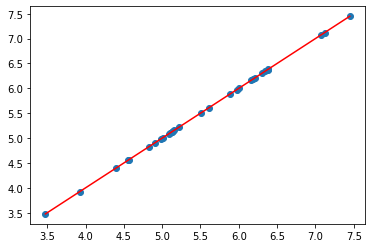

<IPython.core.display.Javascript object>

In [24]:
ymin = y_test.min()
ymax = y_test.max()

plt.scatter(y_test, y_pred)
plt.plot([ymin, ymax], [ymin, ymax], c="red")
plt.show()

In [28]:
error_df = X_test.copy()
error_df["pred"] = y_pred
error_df["actuals"] = y_test
error_df["error"] = y_pred - y_test
error_df["abs_error"] = error_df["error"].abs()
error_df = error_df.sort_values("abs_error", ascending=False)
error_df.shape

(31, 12)

<IPython.core.display.Javascript object>

As we can see the plot above, we're doing a really good job. Our model only missed 32 predictions and they're not far off. 